In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/ods_slack_all.csv')

df.index = df['user'] + '_' + df['ts'].round(0).astype(str)
df['new_ind'] = df.index

def get_pos_score(reactions):
    positive_reactions = {
        'heavy_plus_sign',
        '+1',
        'tnx',
        'omgtnx',
        'muscle',
        'fireball',
        'shaka',
        'fire',
        'heart'
    }
    total_pos_score = 0
    for reaction in reactions:
        if reaction['name'] in positive_reactions:
            total_pos_score += reaction['count']
    return total_pos_score

from tqdm import tqdm_notebook as tqdm

pos_score_dict = {}
for row_ind, row in tqdm(df['reactions'].dropna().iteritems()):
    pos_score = get_pos_score(eval(row))
    pos_score_dict[row_ind] = pos_score

/Users/o/work/PycharmProjects/venvs/wrike/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/o/work/PycharmProjects/venvs/wrike/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [2]:
from collections import defaultdict

all_index = set(df.index)
replies_dict = defaultdict(list)
best_ans = {}
best_ans_pos_score = {}
success_count = 0
fail_count = 0
eval_fail_count = 0

for row_ind, row in tqdm(df[~df['replies'].isnull()].iterrows()):
    try:
        replies = eval(row['replies'])
    except:
        eval_fail_count += 1
    
    for reply in replies:
        new_ind = f'{reply["user"]}_{round(float(reply["ts"]), 0)}'
        
        if new_ind in all_index:
            success_count += 1
            replies_dict[row_ind].append(new_ind)
        else:
            fail_count += 1
            
    if replies_dict[row_ind]:
        current_best_ans = max([(x, pos_score_dict.get(x, 0)) for x in replies_dict[row_ind]], key=lambda x: x[1])
        best_ans[row_ind] = current_best_ans[0]
        best_ans_pos_score[row_ind] = current_best_ans[1]

/Users/o/work/PycharmProjects/venvs/wrike/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [3]:
print('total questios with answers:', len(df[~df['replies'].isnull()]))

total questios with answers: 98131


In [4]:
df['is_answer'] = df['new_ind'].apply(lambda x: x in replies_dict)
print(df['is_answer'].value_counts())

False    1247599
True      125840
Name: is_answer, dtype: int64


In [5]:
df['new_ind'] = df.index
df['best_ans'] = df['new_ind'].apply(lambda x: best_ans.get(x, np.NaN))
df['best_ans_score'] = df['new_ind'].apply(lambda x: best_ans_pos_score.get(x, np.NaN))
df['pos_score'] = df['new_ind'].apply(lambda x: pos_score_dict.get(x, 0))
df = df.query('pos_score > 2')

In [14]:
df[df['is_answer']][['text', 'best_ans_text']]

KeyError: "['best_ans_text'] not in index"

In [16]:
df = pd.read_csv('../data/ods_slack_answers.csv')

/Users/o/work/PycharmProjects/venvs/wrike/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,31,36,37,46,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_new = df[['new_ind', 'text']].rename(columns={'new_ind': 'best_ans', 'text': 'answer_text'})

In [18]:
df = pd.merge(df, df_new, on='best_ans', how='left')

In [19]:
df.shape

(57426, 58)

In [22]:
df[['text', 'answer_text']].dropna(subset=['answer_text'])

,text,answer_text
0,"Добрый день, коллеги. Ищу человека, который см...","Еще накину: лучше не переводи 1:1, а переписыв..."
39,"Привет, коллеги! Учусь по специальности Data S...",не ну вы канеш нового члена ОДС оч токсично вс...
57,Привет!\nЕсть желание сделать социальное прил...,вот это как раз machine learning for social go...
65,"Друзья, в особенности гастролеры с опытом! :co...","Площадку не надо выбивать, я просто приду в де..."
68,Мопед мой! \n\nИщу коуча (тренера/мастера йоду...,Вот тебе библиотечка кванта <https://drive.goo...
...,...,...
57267,"Привет, я Таня.\nЖиву и работаю в Милане дата...",Плюсую обновление аватарки :youknow:
57319,"Всем привет, я Тимур. Мне 18. В этом году пост...","На учёбу можно забить по большей части, сдават..."
57378,"Привет, меня зовут Дина, мне 27. Я работаю в G...",<@U04ELQZAU> относительно ассистента и его экш...
57419,Классный гайд про визуализации и картинки в ри...,"ИМХО, не раскрыта пара тем - печатать ваши илл..."


In [23]:
df.to_csv('../data/ods_answers.csv', index=False)

In [24]:
df

,Unnamed: 0,type,subtype,ts,user,text,channel,old_name,name,reactions,...,no_notifications,permalink,bot_profile,text_len,new_ind,is_answer,best_ans,best_ans_score,pos_score,answer_text
0,17,message,NaN,1.548140e+09,U1NPQ2WPN,"Добрый день, коллеги. Ищу человека, который см...",_call_4_collaboration,NaN,NaN,"[{'name': 'heavy_plus_sign', 'users': ['U99J6E...",...,NaN,NaN,NaN,382,U1NPQ2WPN_1548139899.0,True,U5QBU8SUR_1548238982.0,6.0,8,"Еще накину: лучше не переводи 1:1, а переписыв..."
1,19,message,NaN,1.585138e+09,UK188NRKM,Всем привет! Кто-нибудь нуждается в услугах се...,_call_4_collaboration,NaN,NaN,"[{'name': '+1', 'users': ['U2N853RGF', 'U331LV...",...,NaN,NaN,NaN,625,UK188NRKM_1585138381.0,True,U4ZDFAAA3_1585138974.0,0.0,3,NaN
2,25,message,NaN,1.585176e+09,U0AS1QEJF,"На вопросы, которые ты задал о качественных св...",_call_4_collaboration,NaN,NaN,"[{'name': 'heavy_plus_sign', 'users': ['U04ELQ...",...,NaN,NaN,NaN,609,U0AS1QEJF_1585175724.0,False,NaN,NaN,4,NaN
3,37,message,NaN,1.490462e+09,U27HU84H4,зато остальным начинающим сайентистам гораздо ...,_call_4_collaboration,NaN,NaN,"[{'name': 'heavy_plus_sign', 'users': ['U040HK...",...,NaN,NaN,NaN,187,U27HU84H4_1490461856.0,False,NaN,NaN,5,NaN
4,39,message,NaN,1.490462e+09,U040HKJE7,(продолжая общую мысль про спрашивать в публич...,_call_4_collaboration,NaN,NaN,"[{'name': 'heavy_plus_sign', 'users': ['U0FEJN...",...,NaN,NaN,NaN,233,U040HKJE7_1490462048.0,False,NaN,NaN,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57421,1801512,message,thread_broadcast,1.548151e+09,U4ZNGNPQU,"Бери скрижали, пиши заповеди:\n\n1. *Делай пре...",writing_n_presenting,NaN,NaN,"[{'name': 'jesus', 'users': ['UA7D8TN9F', 'U9V...",...,NaN,NaN,NaN,3537,U4ZNGNPQU_1548151493.0,False,NaN,NaN,34,NaN
57422,1801514,message,NaN,1.561892e+09,U27HU84H4,&gt; arxiv и правда разрешает любой формат\n И...,writing_n_presenting,NaN,NaN,"[{'name': 'tnx', 'users': ['U3L4UC8H4', 'UJW9M...",...,NaN,NaN,NaN,382,U27HU84H4_1561891987.0,False,NaN,NaN,4,NaN
57423,1801617,message,NaN,1.594481e+09,U6Y47FWKX,Привет! Хочу продать в Питере сборку.\nПричина...,юла_ods,NaN,NaN,"[{'name': 'fireball', 'users': ['UC7F3KJ7P', '...",...,NaN,NaN,NaN,528,U6Y47FWKX_1594481308.0,True,U6Y47FWKX_1594481497.0,0.0,11,NaN
57424,1801656,message,NaN,1.598438e+09,UC7F3KJ7P,Продаю девбокс на 1950 тредриппере с 4 x 1080 ...,юла_ods,NaN,NaN,"[{'name': 'fireball', 'users': ['U6Y47FWKX', '...",...,NaN,NaN,NaN,212,UC7F3KJ7P_1598437707.0,True,UC7F3KJ7P_1598453063.0,3.0,9,"Можно, если в течение месяца не продам сборкой..."


In [ ]:
df[['text', '']]

In [133]:
# work_phrases = ['archived the channel',  'has renamed the channel from']
# df[['new_ind', 'text', 'best_ans', 'best_ans_score', 'pos_score']].head()

,new_ind,text,best_ans,best_ans_score,pos_score
U040HKJE7_1534697984.0,U040HKJE7_1534697984.0,"<@U040HKJE7> has renamed the channel from ""_to...",NaN,NaN,0
U040HKJE7_1534697988.0,U040HKJE7_1534697988.0,<@U040HKJE7> archived the channel,NaN,NaN,0
U040HKJE7_1476871730.0,U040HKJE7_1476871730.0,<@U040HKJE7> archived the channel,NaN,NaN,0
U2D7LT3J6_1476264089.0,U2D7LT3J6_1476264089.0,<@U2D7LT3J6> has left the channel,NaN,NaN,0
UJ4QYG82J_1574333435.0,UJ4QYG82J_1574333435.0,"Привет! Могу поучаствовать знаниями про CI/CD,...",NaN,NaN,0


In [144]:
df[['channel', 'text', 'best_ans', 'best_ans_score', 'pos_score']].sort_values('pos_score', ascending=False)

,channel,text,best_ans,best_ans_score,pos_score
U3KTCHLUD_1592367443.0,career,Как я искала работу в СФ во время пандемии\n\n...,U3KTCHLUD_1592597397.0,28.0,462
U6PNWSJL8_1591984911.0,kaggle_crackers,"Сложно осознать, что можно вот так взять и пол...",U6PNWSJL8_1591990643.0,35.0,455
U8XT96DAT_1575025496.0,kaggle_crackers,Что то я тут подумал (видимо потому что пятниц...,U4ZRFG1V0_1575026632.0,14.0,424
U4ZRFG1V0_1555478562.0,career,"Очередной исторический пост о прогрессе, ибо я...",U1UNFRQ1K_1555486858.0,29.0,413
U21MU5ATE_1580264248.0,career,":coolstorybob: про то, как проходил на стажиро...",U21MU5ATE_1580278528.0,3.0,392
...,...,...,...,...,...
U04ELQZAU_1542211289.0,_random_talks,Любая достаточно развитая технология неотличим...,NaN,NaN,3
UA92L7ACC_1595019367.0,lang_python,Тогда не очень получится :pepe_sad:\nА `torch....,NaN,NaN,3
U3HM4KY14_1559582703.0,lang_python,"`np.expand_dims(inp, axis=-1)`",NaN,NaN,3
U04CH4QBD_1467624909.0,lang_python,Написать лист из 12 туплов и apply,NaN,NaN,3


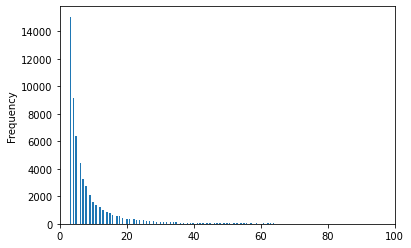

In [142]:

df['pos_score'].plot(kind='hist', bins=1090, xlim=(0, 100));

In [143]:
df.shape

(57425, 56)

In [95]:
success_count

764022

In [96]:
fail_count

106792

In [110]:
get_pos_score(eval(row['reactions']))

9